## 卷积神经网络（Convolutional Neural Network, CNN）

## 项目：实现一个狗品种识别算法App

在这个notebook文件中，模板代码已经提供给大家，用以实现基于卷积神经网络的狗品种识别项目。

---

### 开始吧
在这个notebook中，开发可以作为移动端或 Web应用程序一部分的算法。在本项目的最后，我们的程序将能够把用户提供的任何一个图像作为输入。如果可以从图像中检测到一只狗，它会输出对狗品种的预测。如果图像中是一个人脸，它会预测一个与其最相似的狗的种类。下面这张图展示了完成项目后可能的输出结果。


在现实世界中，你需要拼凑一系列的模型来完成不同的任务；举个例子，用来预测狗种类的算法会与预测人类的算法不同。在做项目的过程中，你可能会遇到不少失败的预测，因为并不存在完美的算法和模型。

---
<a id='step0'></a>
## 步骤 0: 导入数据集

### 导入狗数据集
在下方的代码单元（cell）中，我们导入了一个狗图像的数据集。我们使用 scikit-learn 库中的 `load_files` 函数来获取一些变量：
- `train_files`, `valid_files`, `test_files` - 包含图像的文件路径的numpy数组
- `train_targets`, `valid_targets`, `test_targets` - 包含独热编码分类标签的numpy数组
- `dog_names` - 由字符串构成的与标签相对应的狗的种类

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# 定义函数来加载train，test和validation数据集
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# 加载train，test和validation数据集
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# 加载狗品种列表
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# 打印数据统计描述
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### 导入人脸数据集

在下方的代码单元中，我们导入人脸图像数据集，文件所在路径存储在名为 `human_files` 的 numpy 数组。

In [2]:
import random
random.seed(8675309)

# 加载打乱后的人脸数据集的文件名
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# 打印数据集的数据量
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## 步骤1：检测人脸
 
我们将使用 OpenCV 中的 [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) 来检测图像中的人脸。OpenCV 提供了很多预训练的人脸检测模型，它们以XML文件保存在 [github](https://github.com/opencv/opencv/tree/master/data/haarcascades)。我们已经下载了其中一个检测模型，并且把它存储在 `haarcascades` 的目录中。

Number of faces detected: 1


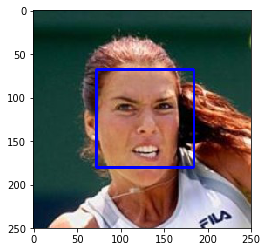

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# 提取预训练的人脸检测模型
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# 加载彩色（通道顺序为BGR）图像
img = cv2.imread(human_files[4])

# 将BGR图像进行灰度处理
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 在图像中找出脸
faces = face_cascade.detectMultiScale(gray)

# 打印图像中检测到的脸的个数
print('Number of faces detected:', len(faces))

# 获取每一个所检测到的脸的识别框
for (x,y,w,h) in faces:
    # 在人脸图像中绘制出识别框
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# 将BGR图像转变为RGB图像以打印
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 展示含有识别框的图像
plt.imshow(cv_rgb)
plt.show()

在使用任何一个检测模型之前，将图像转换为灰度图是常用过程。`detectMultiScale` 函数使用储存在 `face_cascade` 中的的数据，对输入的灰度图像进行分类。

在上方的代码中，`faces` 以 numpy 数组的形式，保存了识别到的面部信息。它其中每一行表示一个被检测到的脸，该数据包括如下四个信息：前两个元素  `x`、`y` 代表识别框左上角的 x 和 y 坐标（参照上图，注意 y 坐标的方向和我们默认的方向不同）；后两个元素代表识别框在 x 和 y 轴两个方向延伸的长度 `w` 和 `d`。 

### 写一个人脸识别器

我们可以将这个程序封装为一个函数。该函数的输入为人脸图像的**路径**，当图像中包含人脸时，该函数返回 `True`，反之返回 `False`。该函数定义如下所示。

In [4]:
# 如果img_path路径表示的图像检测到了脸，返回"True" 
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0


### 评估人脸检测模型

在下方的代码块中，使用 `face_detector` 函数，计算：

- `human_files` 的前100张图像中，能够检测到**人脸**的图像占比多少？
- `dog_files` 的前100张图像中，能够检测到**人脸**的图像占比多少？

理想情况下，人图像中检测到人脸的概率应当为100%，而狗图像中检测到人脸的概率应该为0%。你会发现我们的算法并非完美，但结果仍然是可以接受的。我们从每个数据集中提取前100个图像的文件路径，并将它们存储在`human_files_short`和`dog_files_short`中。

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
## 请不要修改上方代码


## TODO: 基于human_files_short和dog_files_short
## 中的图像测试face_detector的表现
##human_number = 0
# human_proportion = 0
# dog_number = 0
# dog_proportion = 0
# for i in range(100):
#     if face_detector(human_files_short[i]) == True:
#         human_number += 1
#     if face_detector(dog_files_short[i]) == True:
#         dog_number += 1
# human_proportion = human_number / float(100)
# dog_proportion = dog_number / float(100)
# print('%.2f%%' % (human_proportion * 100))
# print('%.2f%%' % (dog_proportion * 100))
    
human_number = sum([face_detector(f) for f in human_files_short])
human_proportion = human_number / len(human_files_short)
print('{:.2%}'.format(human_proportion))

dog_number = sum([face_detector(f) for f in dog_files_short])
dog_proportion = dog_number / len(dog_files_short)
print('{:.2%}'.format(dog_proportion))

99.00%
11.00%


---
<a id='step2'></a>

## 步骤 2: 检测狗狗

在这个部分中，我们使用预训练的 [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) 模型去检测图像中的狗。下方的第一行代码就是下载了 ResNet-50 模型的网络结构参数，以及基于 [ImageNet](http://www.image-net.org/) 数据集的预训练权重。

ImageNet 这目前一个非常流行的数据集，常被用来测试图像分类等计算机视觉任务相关的算法。它包含超过一千万个 URL，每一个都链接到 [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 中所对应的一个物体的图像。任给输入一个图像，该 ResNet-50 模型会返回一个对图像中物体的预测结果。

In [6]:
from keras.applications.resnet50 import ResNet50

# 定义ResNet50模型
ResNet50_model = ResNet50(weights='imagenet')

### 数据预处理

- 在使用 TensorFlow 作为后端的时候，在 Keras 中，CNN 的输入是一个4维数组（也被称作4维张量），它的各维度尺寸为 `(nb_samples, rows, columns, channels)`。其中 `nb_samples` 表示图像（或者样本）的总数，`rows`, `columns`, 和 `channels` 分别表示图像的行数、列数和通道数。


- 下方的 `path_to_tensor` 函数实现如下将彩色图像的字符串型的文件路径作为输入，返回一个4维张量，作为 Keras CNN 输入。因为我们的输入图像是彩色图像，因此它们具有三个通道（ `channels` 为 `3`）。
    1. 该函数首先读取一张图像，然后将其缩放为 224×224 的图像。
    2. 随后，该图像被调整为具有4个维度的张量。
    3. 对于任一输入图像，最后返回的张量的维度是：`(1, 224, 224, 3)`。


- `paths_to_tensor` 函数将图像路径的字符串组成的 numpy 数组作为输入，并返回一个4维张量，各维度尺寸为 `(nb_samples, 224, 224, 3)`。 在这里，`nb_samples`是提供的图像路径的数据中的样本数量或图像数量。你也可以将 `nb_samples` 理解为数据集中3维张量的个数（每个3维张量表示一个不同的图像。

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(224, 224))
    # 将PIL.Image.Image类型转化为格式为(224, 224, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, 224, 224, 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)



### 基于 ResNet-50 架构进行预测

对于通过上述步骤得到的四维张量，在把它们输入到 ResNet-50 网络、或 Keras 中其他类似的预训练模型之前，还需要进行一些额外的处理：
1. 首先，这些图像的通道顺序为 RGB，我们需要重排他们的通道顺序为 BGR。
2. 其次，预训练模型的输入都进行了额外的归一化过程。因此我们在这里也要对这些张量进行归一化，即对所有图像所有像素都减去像素均值 `[103.939, 116.779, 123.68]`（以 RGB 模式表示，根据所有的 ImageNet 图像算出）。

导入的 `preprocess_input` 函数实现了这些功能。如果你对此很感兴趣，可以在 [这里](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py) 查看 `preprocess_input`的代码。


在实现了图像处理的部分之后，我们就可以使用模型来进行预测。这一步通过 `predict` 方法来实现，它返回一个向量，向量的第 i 个元素表示该图像属于第 i 个 ImageNet 类别的概率。这通过如下的 `ResNet50_predict_labels` 函数实现。

通过对预测出的向量取用 argmax 函数（找到有最大概率值的下标序号），我们可以得到一个整数，即模型预测到的物体的类别。进而根据这个 [清单](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)，我们能够知道这具体是哪个品种的狗狗。


In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
def ResNet50_predict_labels(img_path):
    # 返回img_path路径的图像的预测向量
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### 完成狗检测模型


在研究该 [清单](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 的时候，你会注意到，狗类别对应的序号为151-268。因此，在检查预训练模型判断图像是否包含狗的时候，我们只需要检查如上的 `ResNet50_predict_labels` 函数是否返回一个介于151和268之间（包含区间端点）的值。

我们通过这些想法来完成下方的 `dog_detector` 函数，如果从图像中检测到狗就返回 `True`，否则返回 `False`。

In [9]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [10]:
### TODO: 测试dog_detector函数在human_files_short和dog_files_short的表现
human_number_ResNet50 = 0
human_proportion_ResNet50 = 0
dog_number_ResNet50 = 0
dog_proportion_ResNet50 = 0
for i in range(100):
    if dog_detector(human_files_short[i]) == True:
        human_number_ResNet50 += 1
    if dog_detector(dog_files_short[i]) == True:
        dog_number_ResNet50 += 1
human_proportion_ResNet50 = human_number_ResNet50 / float(100)
dog_proportion_ResNet50 = dog_number_ResNet50 / float(100)
print('%.2f%%' % (human_proportion_ResNet50 * 100))
print('%.2f%%' % (dog_proportion_ResNet50 * 100))



1.00%
100.00%


---

<a id='step3'></a>

## 步骤 3: 从头开始创建一个CNN来分类狗品种


现在我们已经实现了一个函数，能够在图像中识别人类及狗狗。但我们需要更进一步的方法，来对狗的类别进行识别。在这一步中，你需要实现一个卷积神经网络来对狗的品种进行分类。你需要__从头实现__你的卷积神经网络（在这一阶段，你还不能使用迁移学习），并且你需要达到超过1%的测试集准确率。在本项目的步骤五种，你还有机会使用迁移学习来实现一个准确率大大提高的模型。

在添加卷积层的时候，注意不要加上太多的（可训练的）层。更多的参数意味着更长的训练时间，也就是说你更可能需要一个 GPU 来加速训练过程。万幸的是，Keras 提供了能够轻松预测每次迭代（epoch）花费时间所需的函数。你可以据此推断你算法所需的训练时间。

值得注意的是，对狗的图像进行分类是一项极具挑战性的任务。因为即便是一个正常人，也很难区分布列塔尼犬和威尔士史宾格犬。

我们也提到了随机分类将得到一个非常低的结果：不考虑品种略有失衡的影响，随机猜测到正确品种的概率是1/133，相对应的准确率是低于1%的。

请记住，在深度学习领域，实践远远高于理论。


### 数据预处理


通过对每张图像的像素值除以255，我们对图像实现了归一化处理。

In [33]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# Keras中的数据预处理过程
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255



100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:18<00:00, 45.61it/s]


In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: 定义你的网络架构
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='valid', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'))
model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, strides=1, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='relu'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [13]:
## 编译模型
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
from keras.callbacks import ModelCheckpoint  

### 设置训练模型的epochs的数量

epochs = 5


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5


4020/6680 [=================>............] - ETA: 5:43 - loss: 11.5922 - acc: 0.0000e+ - ETA: 4:01 - loss: 12.0815 - acc: 0.0000e+ - ETA: 3:26 - loss: 11.6782 - acc: 0.0000e+ - ETA: 3:08 - loss: 11.9440 - acc: 0.0000e+ - ETA: 2:58 - loss: 11.9619 - acc: 0.0000e+ - ETA: 2:50 - loss: 11.6385 - acc: 0.0000e+ - ETA: 2:44 - loss: 11.7135 - acc: 0.0000e+ - ETA: 2:40 - loss: 11.6156 - acc: 0.0000e+ - ETA: 2:37 - loss: 11.6002 - acc: 0.0000e+ - ETA: 2:34 - loss: 11.7525 - acc: 0.0000e+ - ETA: 2:32 - loss: 11.8236 - acc: 0.0000e+ - ETA: 2:30 - loss: 11.7818 - acc: 0.0000e+ - ETA: 2:28 - loss: 11.8408 - acc: 0.0000e+ - ETA: 2:27 - loss: 11.8411 - acc: 0.0036   - ETA: 2:26 - loss: 11.8020 - acc: 0.00 - ETA: 2:24 - loss: 11.8756 - acc: 0.00 - ETA: 2:23 - loss: 11.8909 - acc: 0.00 - ETA: 2:22 - loss: 11.9242 - acc: 0.00 - ETA: 2:21 - loss: 12.0332 - acc: 0.00 - ETA: 2:21 - loss: 11.9418 - acc: 0.00 - ETA: 2:20 - loss: 11.9149 - acc: 0.00 - ETA: 2:19 - loss: 11.9106 - acc: 0.00 - ETA: 2:18 - loss: 1

6680/6680 [==============================] - ETA: 56s - loss: 11.8539 - acc: 0.005 - ETA: 55s - loss: 11.8500 - acc: 0.005 - ETA: 55s - loss: 11.8523 - acc: 0.005 - ETA: 55s - loss: 11.8452 - acc: 0.005 - ETA: 54s - loss: 11.8361 - acc: 0.005 - ETA: 54s - loss: 11.8449 - acc: 0.005 - ETA: 53s - loss: 11.8448 - acc: 0.005 - ETA: 53s - loss: 11.8535 - acc: 0.005 - ETA: 52s - loss: 11.8530 - acc: 0.006 - ETA: 52s - loss: 11.8499 - acc: 0.005 - ETA: 52s - loss: 11.8527 - acc: 0.005 - ETA: 51s - loss: 11.8585 - acc: 0.005 - ETA: 51s - loss: 11.8586 - acc: 0.005 - ETA: 50s - loss: 11.8638 - acc: 0.005 - ETA: 50s - loss: 11.8661 - acc: 0.005 - ETA: 49s - loss: 11.8627 - acc: 0.005 - ETA: 49s - loss: 11.8739 - acc: 0.005 - ETA: 49s - loss: 11.8704 - acc: 0.005 - ETA: 48s - loss: 11.8725 - acc: 0.005 - ETA: 48s - loss: 11.8777 - acc: 0.005 - ETA: 47s - loss: 11.8830 - acc: 0.005 - ETA: 47s - loss: 11.8936 - acc: 0.005 - ETA: 47s - loss: 11.8904 - acc: 0.005 - ETA: 46s - loss: 11.8839 - acc: 0.0

4080/6680 [=================>............] - ETA: 2:15 - loss: 10.3066 - acc: 0.05 - ETA: 2:14 - loss: 11.6559 - acc: 0.02 - ETA: 2:14 - loss: 12.7245 - acc: 0.01 - ETA: 2:14 - loss: 12.6392 - acc: 0.01 - ETA: 2:13 - loss: 12.3145 - acc: 0.01 - ETA: 2:13 - loss: 11.9880 - acc: 0.02 - ETA: 2:13 - loss: 12.1218 - acc: 0.02 - ETA: 2:12 - loss: 12.2340 - acc: 0.01 - ETA: 2:12 - loss: 12.2412 - acc: 0.02 - ETA: 2:12 - loss: 12.3192 - acc: 0.03 - ETA: 2:11 - loss: 12.2603 - acc: 0.03 - ETA: 2:11 - loss: 12.3160 - acc: 0.02 - ETA: 2:11 - loss: 12.5101 - acc: 0.03 - ETA: 2:10 - loss: 12.4134 - acc: 0.02 - ETA: 2:10 - loss: 12.4880 - acc: 0.02 - ETA: 2:10 - loss: 12.4782 - acc: 0.02 - ETA: 2:09 - loss: 12.5783 - acc: 0.02 - ETA: 2:09 - loss: 12.5628 - acc: 0.02 - ETA: 2:08 - loss: 12.5811 - acc: 0.02 - ETA: 2:08 - loss: 12.5689 - acc: 0.02 - ETA: 2:08 - loss: 12.6183 - acc: 0.02 - ETA: 2:07 - loss: 12.5826 - acc: 0.02 - ETA: 2:07 - loss: 12.5681 - acc: 0.02 - ETA: 2:06 - loss: 12.6126 - acc: 0.

6680/6680 [==============================] - ETA: 52s - loss: 13.2004 - acc: 0.011 - ETA: 52s - loss: 13.1874 - acc: 0.010 - ETA: 52s - loss: 13.1905 - acc: 0.010 - ETA: 51s - loss: 13.1865 - acc: 0.010 - ETA: 51s - loss: 13.1768 - acc: 0.010 - ETA: 50s - loss: 13.1733 - acc: 0.010 - ETA: 50s - loss: 13.1694 - acc: 0.010 - ETA: 50s - loss: 13.1657 - acc: 0.010 - ETA: 49s - loss: 13.1594 - acc: 0.010 - ETA: 49s - loss: 13.1616 - acc: 0.010 - ETA: 48s - loss: 13.1577 - acc: 0.010 - ETA: 48s - loss: 13.1657 - acc: 0.010 - ETA: 48s - loss: 13.1510 - acc: 0.010 - ETA: 47s - loss: 13.1447 - acc: 0.010 - ETA: 47s - loss: 13.1354 - acc: 0.010 - ETA: 46s - loss: 13.1236 - acc: 0.010 - ETA: 46s - loss: 13.1142 - acc: 0.010 - ETA: 45s - loss: 13.1078 - acc: 0.010 - ETA: 45s - loss: 13.1075 - acc: 0.010 - ETA: 45s - loss: 13.1154 - acc: 0.010 - ETA: 44s - loss: 13.1177 - acc: 0.010 - ETA: 44s - loss: 13.1146 - acc: 0.010 - ETA: 43s - loss: 13.1117 - acc: 0.010 - ETA: 43s - loss: 13.1167 - acc: 0.0

4080/6680 [=================>............] - ETA: 2:17 - loss: 13.6242 - acc: 0.0000e+ - ETA: 2:17 - loss: 13.0211 - acc: 0.0000e+ - ETA: 2:15 - loss: 11.9547 - acc: 0.0167   - ETA: 2:14 - loss: 12.0417 - acc: 0.01 - ETA: 2:14 - loss: 12.6138 - acc: 0.01 - ETA: 2:14 - loss: 12.3853 - acc: 0.00 - ETA: 2:13 - loss: 12.5544 - acc: 0.00 - ETA: 2:13 - loss: 12.3743 - acc: 0.00 - ETA: 2:12 - loss: 12.3724 - acc: 0.00 - ETA: 2:12 - loss: 12.5003 - acc: 0.00 - ETA: 2:12 - loss: 12.4899 - acc: 0.00 - ETA: 2:11 - loss: 12.4276 - acc: 0.00 - ETA: 2:11 - loss: 12.4338 - acc: 0.00 - ETA: 2:10 - loss: 12.5614 - acc: 0.00 - ETA: 2:10 - loss: 12.4252 - acc: 0.00 - ETA: 2:10 - loss: 12.4233 - acc: 0.00 - ETA: 2:09 - loss: 12.4927 - acc: 0.00 - ETA: 2:09 - loss: 12.5609 - acc: 0.00 - ETA: 2:08 - loss: 12.5225 - acc: 0.00 - ETA: 2:08 - loss: 12.5799 - acc: 0.00 - ETA: 2:08 - loss: 12.4834 - acc: 0.00 - ETA: 2:07 - loss: 12.5355 - acc: 0.00 - ETA: 2:07 - loss: 12.5303 - acc: 0.00 - ETA: 2:06 - loss: 12.55

6680/6680 [==============================] - ETA: 54s - loss: 11.5570 - acc: 0.009 - ETA: 53s - loss: 11.5557 - acc: 0.009 - ETA: 53s - loss: 11.5601 - acc: 0.009 - ETA: 53s - loss: 11.5555 - acc: 0.009 - ETA: 52s - loss: 11.5482 - acc: 0.009 - ETA: 52s - loss: 11.5410 - acc: 0.009 - ETA: 51s - loss: 11.5249 - acc: 0.009 - ETA: 51s - loss: 11.5180 - acc: 0.009 - ETA: 50s - loss: 11.5108 - acc: 0.009 - ETA: 50s - loss: 11.5126 - acc: 0.009 - ETA: 50s - loss: 11.5054 - acc: 0.009 - ETA: 49s - loss: 11.5238 - acc: 0.009 - ETA: 49s - loss: 11.5255 - acc: 0.009 - ETA: 48s - loss: 11.5327 - acc: 0.009 - ETA: 48s - loss: 11.5366 - acc: 0.009 - ETA: 47s - loss: 11.5296 - acc: 0.009 - ETA: 47s - loss: 11.5282 - acc: 0.009 - ETA: 47s - loss: 11.5350 - acc: 0.009 - ETA: 46s - loss: 11.5341 - acc: 0.009 - ETA: 46s - loss: 11.5406 - acc: 0.009 - ETA: 45s - loss: 11.5387 - acc: 0.009 - ETA: 45s - loss: 11.5350 - acc: 0.009 - ETA: 45s - loss: 11.5230 - acc: 0.009 - ETA: 44s - loss: 11.5295 - acc: 0.0

4080/6680 [=================>............] - ETA: 2:22 - loss: 10.6613 - acc: 0.05 - ETA: 2:22 - loss: 10.9192 - acc: 0.02 - ETA: 2:24 - loss: 10.7889 - acc: 0.01 - ETA: 2:24 - loss: 10.4452 - acc: 0.01 - ETA: 2:24 - loss: 10.8472 - acc: 0.01 - ETA: 2:23 - loss: 10.4954 - acc: 0.00 - ETA: 2:23 - loss: 10.7011 - acc: 0.00 - ETA: 2:24 - loss: 10.9187 - acc: 0.00 - ETA: 2:23 - loss: 11.0223 - acc: 0.01 - ETA: 2:23 - loss: 10.9066 - acc: 0.01 - ETA: 2:22 - loss: 10.8775 - acc: 0.00 - ETA: 2:21 - loss: 10.8782 - acc: 0.00 - ETA: 2:20 - loss: 10.7767 - acc: 0.01 - ETA: 2:19 - loss: 10.7278 - acc: 0.01 - ETA: 2:19 - loss: 10.8865 - acc: 0.01 - ETA: 2:18 - loss: 10.8302 - acc: 0.00 - ETA: 2:17 - loss: 10.8170 - acc: 0.00 - ETA: 2:16 - loss: 10.8385 - acc: 0.00 - ETA: 2:16 - loss: 10.9564 - acc: 0.00 - ETA: 2:15 - loss: 11.0694 - acc: 0.00 - ETA: 2:14 - loss: 11.1126 - acc: 0.00 - ETA: 2:14 - loss: 10.9902 - acc: 0.00 - ETA: 2:13 - loss: 10.9180 - acc: 0.00 - ETA: 2:13 - loss: 10.9855 - acc: 0.

6680/6680 [==============================] - ETA: 56s - loss: 11.6070 - acc: 0.010 - ETA: 56s - loss: 11.6108 - acc: 0.010 - ETA: 55s - loss: 11.6179 - acc: 0.010 - ETA: 55s - loss: 11.6097 - acc: 0.010 - ETA: 54s - loss: 11.6017 - acc: 0.010 - ETA: 54s - loss: 11.6174 - acc: 0.010 - ETA: 53s - loss: 11.6301 - acc: 0.010 - ETA: 53s - loss: 11.6276 - acc: 0.010 - ETA: 53s - loss: 11.6400 - acc: 0.010 - ETA: 52s - loss: 11.6406 - acc: 0.010 - ETA: 52s - loss: 11.6468 - acc: 0.010 - ETA: 51s - loss: 11.6529 - acc: 0.010 - ETA: 51s - loss: 11.6450 - acc: 0.009 - ETA: 50s - loss: 11.6481 - acc: 0.009 - ETA: 50s - loss: 11.6484 - acc: 0.009 - ETA: 50s - loss: 11.6570 - acc: 0.010 - ETA: 49s - loss: 11.6660 - acc: 0.010 - ETA: 49s - loss: 11.6717 - acc: 0.009 - ETA: 48s - loss: 11.6714 - acc: 0.009 - ETA: 48s - loss: 11.6827 - acc: 0.009 - ETA: 47s - loss: 11.6944 - acc: 0.009 - ETA: 47s - loss: 11.7005 - acc: 0.009 - ETA: 47s - loss: 11.6978 - acc: 0.009 - ETA: 46s - loss: 11.7041 - acc: 0.0

4040/6680 [=================>............] - ETA: 2:19 - loss: 13.5200 - acc: 0.0000e+ - ETA: 2:22 - loss: 14.1670 - acc: 0.0000e+ - ETA: 2:22 - loss: 13.7461 - acc: 0.0000e+ - ETA: 2:22 - loss: 13.8576 - acc: 0.0000e+ - ETA: 2:21 - loss: 13.1577 - acc: 0.0000e+ - ETA: 2:21 - loss: 13.1081 - acc: 0.0000e+ - ETA: 2:20 - loss: 12.9848 - acc: 0.0000e+ - ETA: 2:20 - loss: 13.0527 - acc: 0.0000e+ - ETA: 2:20 - loss: 12.9024 - acc: 0.0000e+ - ETA: 2:19 - loss: 12.9707 - acc: 0.0000e+ - ETA: 2:21 - loss: 13.0241 - acc: 0.0000e+ - ETA: 2:22 - loss: 13.2269 - acc: 0.0000e+ - ETA: 2:21 - loss: 13.3498 - acc: 0.0000e+ - ETA: 2:21 - loss: 13.4562 - acc: 0.0000e+ - ETA: 2:20 - loss: 13.5523 - acc: 0.0000e+ - ETA: 2:20 - loss: 13.4740 - acc: 0.0000e+ - ETA: 2:19 - loss: 13.5543 - acc: 0.0000e+ - ETA: 2:18 - loss: 13.4791 - acc: 0.0000e+ - ETA: 2:17 - loss: 13.5141 - acc: 0.0026   - ETA: 2:16 - loss: 13.5802 - acc: 0.00 - ETA: 2:16 - loss: 13.3945 - acc: 0.00 - ETA: 2:16 - loss: 13.3733 - acc: 0.00 -

6680/6680 [==============================] - ETA: 56s - loss: 13.7167 - acc: 0.008 - ETA: 55s - loss: 13.7218 - acc: 0.008 - ETA: 55s - loss: 13.7300 - acc: 0.008 - ETA: 54s - loss: 13.7416 - acc: 0.008 - ETA: 54s - loss: 13.7509 - acc: 0.008 - ETA: 53s - loss: 13.7623 - acc: 0.007 - ETA: 53s - loss: 13.7607 - acc: 0.007 - ETA: 53s - loss: 13.7621 - acc: 0.007 - ETA: 52s - loss: 13.7638 - acc: 0.007 - ETA: 52s - loss: 13.7687 - acc: 0.007 - ETA: 51s - loss: 13.7765 - acc: 0.007 - ETA: 51s - loss: 13.7779 - acc: 0.007 - ETA: 51s - loss: 13.7823 - acc: 0.007 - ETA: 50s - loss: 13.7835 - acc: 0.008 - ETA: 50s - loss: 13.7912 - acc: 0.008 - ETA: 49s - loss: 13.7979 - acc: 0.008 - ETA: 49s - loss: 13.8085 - acc: 0.008 - ETA: 48s - loss: 13.8159 - acc: 0.008 - ETA: 48s - loss: 13.8144 - acc: 0.007 - ETA: 48s - loss: 13.8219 - acc: 0.007 - ETA: 47s - loss: 13.8291 - acc: 0.007 - ETA: 47s - loss: 13.8332 - acc: 0.007 - ETA: 46s - loss: 13.8433 - acc: 0.007 - ETA: 46s - loss: 13.8503 - acc: 0.0

In [15]:
## 加载具有最好验证loss的模型

model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### 测试模型

在狗图像的测试数据集上试用你的模型。

In [16]:
# 获取测试数据集中每一个图像所预测的狗品种的index
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 0.9569%


---
<a id='step4'></a>
## 步骤 4: 使用一个CNN来区分狗的品种


使用 迁移学习（Transfer Learning）的方法，能帮助我们在不损失准确率的情况下大大减少训练时间。在以下步骤中，你可以尝试使用迁移学习来训练你自己的CNN。


### 得到从图像中提取的特征向量（Bottleneck Features）

In [17]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### 模型架构

该模型使用预训练的 VGG-16 模型作为固定的图像特征提取器，其中 VGG-16 最后一层卷积层的输出被直接输入到我们的模型。我们只需要添加一个全局平均池化层以及一个全连接层，其中全连接层使用 softmax 激活函数，对每一个狗的种类都包含一个节点。

In [18]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### 编译模型

In [19]:
## 编译模型

VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### 训练模型

In [20]:
## 训练模型

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)



Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 2:25 - loss: 15.1353 - acc: 0.0000e+ - ETA: 14s - loss: 14.6814 - acc: 0.0182     - ETA: 7s - loss: 14.6481 - acc: 0.018 - ETA: 5s - loss: 14.4018 - acc: 0.02 - ETA: 4s - loss: 14.2225 - acc: 0.02 - ETA: 3s - loss: 14.0023 - acc: 0.03 - ETA: 3s - loss: 13.9873 - acc: 0.03 - ETA: 2s - loss: 13.8095 - acc: 0.03 - ETA: 2s - loss: 13.7493 - acc: 0.04 - ETA: 2s - loss: 13.6579 - acc: 0.04 - ETA: 2s - loss: 13.5629 - acc: 0.04 - ETA: 1s - loss: 13.4974 - acc: 0.05 - ETA: 1s - loss: 13.3432 - acc: 0.05 - ETA: 1s - loss: 13.3115 - acc: 0.05 - ETA: 1s - loss: 13.2233 - acc: 0.06 - ETA: 1s - loss: 13.0883 - acc: 0.06 - ETA: 1s - loss: 13.0465 - acc: 0.06 - ETA: 1s - loss: 12.9213 - acc: 0.07 - ETA: 1s - loss: 12.8313 - acc: 0.07 - ETA: 1s - loss: 12.6995 - acc: 0.08 - ETA: 0s - loss: 12.6310 - acc: 0.08 - ETA: 0s - loss: 12.5407 - acc: 0.09 - ETA: 0s - loss: 12.4337 - acc: 0.09 - ETA: 0s -

6680/6680 [==============================] - ETA: 1s - loss: 5.6472 - acc: 0.650 - ETA: 1s - loss: 7.4551 - acc: 0.485 - ETA: 1s - loss: 7.5079 - acc: 0.505 - ETA: 1s - loss: 7.5912 - acc: 0.500 - ETA: 1s - loss: 7.3812 - acc: 0.513 - ETA: 1s - loss: 7.3979 - acc: 0.506 - ETA: 1s - loss: 7.3751 - acc: 0.509 - ETA: 1s - loss: 7.2613 - acc: 0.516 - ETA: 1s - loss: 7.3774 - acc: 0.503 - ETA: 1s - loss: 7.3797 - acc: 0.502 - ETA: 1s - loss: 7.3526 - acc: 0.507 - ETA: 1s - loss: 7.3194 - acc: 0.508 - ETA: 1s - loss: 7.2775 - acc: 0.511 - ETA: 1s - loss: 7.2266 - acc: 0.514 - ETA: 0s - loss: 7.3141 - acc: 0.509 - ETA: 0s - loss: 7.3396 - acc: 0.507 - ETA: 0s - loss: 7.3126 - acc: 0.509 - ETA: 0s - loss: 7.3698 - acc: 0.506 - ETA: 0s - loss: 7.3817 - acc: 0.505 - ETA: 0s - loss: 7.3687 - acc: 0.506 - ETA: 0s - loss: 7.3519 - acc: 0.508 - ETA: 0s - loss: 7.3732 - acc: 0.506 - ETA: 0s - loss: 7.3771 - acc: 0.506 - ETA: 0s - loss: 7.3412 - acc: 0.509 - ETA: 0s - loss: 7.3587 - acc: 0.507 - ETA: 

6680/6680 [==============================] - ETA: 2s - loss: 2.5908 - acc: 0.750 - ETA: 1s - loss: 5.8499 - acc: 0.600 - ETA: 1s - loss: 6.2276 - acc: 0.578 - ETA: 1s - loss: 6.0367 - acc: 0.594 - ETA: 1s - loss: 6.2644 - acc: 0.576 - ETA: 1s - loss: 6.3906 - acc: 0.569 - ETA: 1s - loss: 6.4224 - acc: 0.570 - ETA: 1s - loss: 6.4675 - acc: 0.568 - ETA: 1s - loss: 6.4874 - acc: 0.569 - ETA: 1s - loss: 6.4517 - acc: 0.569 - ETA: 1s - loss: 6.4301 - acc: 0.570 - ETA: 1s - loss: 6.4113 - acc: 0.571 - ETA: 0s - loss: 6.4617 - acc: 0.569 - ETA: 0s - loss: 6.4265 - acc: 0.571 - ETA: 0s - loss: 6.4251 - acc: 0.570 - ETA: 0s - loss: 6.3937 - acc: 0.573 - ETA: 0s - loss: 6.4315 - acc: 0.570 - ETA: 0s - loss: 6.4757 - acc: 0.567 - ETA: 0s - loss: 6.4680 - acc: 0.568 - ETA: 0s - loss: 6.4965 - acc: 0.565 - ETA: 0s - loss: 6.5046 - acc: 0.565 - ETA: 0s - loss: 6.4744 - acc: 0.567 - ETA: 0s - loss: 6.4711 - acc: 0.568 - ETA: 0s - loss: 6.4898 - acc: 0.566 - ETA: 0s - loss: 6.4750 - acc: 0.567 - ETA: 

6680/6680 [==============================] - ETA: 1s - loss: 4.8375 - acc: 0.700 - ETA: 1s - loss: 5.8802 - acc: 0.620 - ETA: 1s - loss: 5.6011 - acc: 0.638 - ETA: 1s - loss: 5.8997 - acc: 0.623 - ETA: 1s - loss: 6.0125 - acc: 0.619 - ETA: 1s - loss: 6.0159 - acc: 0.617 - ETA: 1s - loss: 5.8800 - acc: 0.627 - ETA: 1s - loss: 5.9237 - acc: 0.624 - ETA: 1s - loss: 5.9051 - acc: 0.625 - ETA: 1s - loss: 6.0044 - acc: 0.619 - ETA: 1s - loss: 5.9490 - acc: 0.622 - ETA: 1s - loss: 5.8963 - acc: 0.625 - ETA: 1s - loss: 5.8597 - acc: 0.626 - ETA: 0s - loss: 5.8968 - acc: 0.623 - ETA: 0s - loss: 5.8466 - acc: 0.627 - ETA: 0s - loss: 5.8915 - acc: 0.625 - ETA: 0s - loss: 5.9592 - acc: 0.620 - ETA: 0s - loss: 5.9844 - acc: 0.619 - ETA: 0s - loss: 5.9615 - acc: 0.619 - ETA: 0s - loss: 5.9436 - acc: 0.621 - ETA: 0s - loss: 5.9327 - acc: 0.621 - ETA: 0s - loss: 5.9184 - acc: 0.623 - ETA: 0s - loss: 5.8791 - acc: 0.625 - ETA: 0s - loss: 5.8904 - acc: 0.624 - ETA: 0s - loss: 5.9059 - acc: 0.623 - ETA: 

In [21]:
## 加载具有最好验证loss的模型

VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### 测试模型

In [22]:
# 获取测试数据集中每一个图像所预测的狗品种的index
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 51.3158%


### 使用模型预测狗的品种

In [23]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # 提取bottleneck特征
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # 获取预测向量
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # 返回此模型预测的狗的品种
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## 步骤 5: 建立一个CNN来分类狗的品种（使用迁移学习）

现在你将使用迁移学习来建立一个CNN，从而可以从图像中识别狗的品种。你的 CNN 在测试集上的准确率必须至少达到60%。

在步骤4中，我们使用了迁移学习来创建一个使用基于 VGG-16 提取的特征向量来搭建一个 CNN。在本部分内容中，你必须使用另一个预训练模型来搭建一个 CNN。为了让这个任务更易实现，我们已经预先对目前 keras 中可用的几种网络进行了预训练：

- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

这些文件被命名为为：

    Dog{network}Data.npz

其中 `{network}` 可以是 `VGG19`、`Resnet50`、`InceptionV3` 或 `Xception` 中的一个。选择上方网络架构中的一个，下载相对应的bottleneck特征，并将所下载的文件保存在目录 `bottleneck_features/` 中。


### 获取模型的特征向量

在下方代码块中，通过运行下方代码提取训练、测试与验证集相对应的bottleneck特征。

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [24]:
### 从另一个预训练的CNN获取bottleneck特征
bottleneck_features = np.load('bottleneck_features/DogResNet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']


In [25]:
### 定义框架
Transfer_ResNet50_model = Sequential()
Transfer_ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
Transfer_ResNet50_model.add(Dense(133, activation='softmax'))

Transfer_ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [26]:
### 编译模型
Transfer_ResNet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [27]:
### 训练模型
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

Transfer_ResNet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 2:24 - loss: 5.6306 - acc: 0.0000e+0 - ETA: 15s - loss: 5.8305 - acc: 0.0450    - ETA: 8s - loss: 5.2401 - acc: 0.0675 - ETA: 5s - loss: 4.7327 - acc: 0.122 - ETA: 4s - loss: 4.2712 - acc: 0.183 - ETA: 3s - loss: 3.9343 - acc: 0.216 - ETA: 3s - loss: 3.6416 - acc: 0.254 - ETA: 2s - loss: 3.4217 - acc: 0.277 - ETA: 2s - loss: 3.2201 - acc: 0.313 - ETA: 2s - loss: 3.0253 - acc: 0.348 - ETA: 2s - loss: 2.8741 - acc: 0.369 - ETA: 1s - loss: 2.7611 - acc: 0.387 - ETA: 1s - loss: 2.6585 - acc: 0.404 - ETA: 1s - loss: 2.5645 - acc: 0.422 - ETA: 1s - loss: 2.4786 - acc: 0.438 - ETA: 1s - loss: 2.3904 - acc: 0.456 - ETA: 1s - loss: 2.3077 - acc: 0.472 - ETA: 1s - loss: 2.2345 - acc: 0.486 - ETA: 1s - loss: 2.1645 - acc: 0.497 - ETA: 0s - loss: 2.1089 - acc: 0.507 - ETA: 0s - loss: 2.0645 - acc: 0.514 - ETA: 0s - loss: 2.0161 - acc: 0.523 - ETA: 0s - loss: 1.9692 - acc: 0.532 - ETA: 0s - l

6680/6680 [==============================] - ETA: 2s - loss: 0.0107 - acc: 1.000 - ETA: 1s - loss: 0.0629 - acc: 0.990 - ETA: 1s - loss: 0.0593 - acc: 0.988 - ETA: 1s - loss: 0.0577 - acc: 0.988 - ETA: 1s - loss: 0.0728 - acc: 0.979 - ETA: 1s - loss: 0.0751 - acc: 0.976 - ETA: 1s - loss: 0.0731 - acc: 0.978 - ETA: 1s - loss: 0.0690 - acc: 0.980 - ETA: 1s - loss: 0.0648 - acc: 0.982 - ETA: 1s - loss: 0.0645 - acc: 0.982 - ETA: 1s - loss: 0.0623 - acc: 0.983 - ETA: 1s - loss: 0.0645 - acc: 0.983 - ETA: 1s - loss: 0.0696 - acc: 0.982 - ETA: 1s - loss: 0.0684 - acc: 0.981 - ETA: 1s - loss: 0.0695 - acc: 0.980 - ETA: 0s - loss: 0.0720 - acc: 0.979 - ETA: 0s - loss: 0.0735 - acc: 0.978 - ETA: 0s - loss: 0.0789 - acc: 0.977 - ETA: 0s - loss: 0.0793 - acc: 0.977 - ETA: 0s - loss: 0.0807 - acc: 0.977 - ETA: 0s - loss: 0.0813 - acc: 0.977 - ETA: 0s - loss: 0.0796 - acc: 0.977 - ETA: 0s - loss: 0.0820 - acc: 0.976 - ETA: 0s - loss: 0.0816 - acc: 0.976 - ETA: 0s - loss: 0.0811 - acc: 0.976 - ETA: 

6680/6680 [==============================] - ETA: 2s - loss: 0.0038 - acc: 1.000 - ETA: 1s - loss: 0.0347 - acc: 0.991 - ETA: 1s - loss: 0.0301 - acc: 0.990 - ETA: 1s - loss: 0.0248 - acc: 0.992 - ETA: 1s - loss: 0.0213 - acc: 0.994 - ETA: 1s - loss: 0.0207 - acc: 0.994 - ETA: 1s - loss: 0.0195 - acc: 0.994 - ETA: 1s - loss: 0.0181 - acc: 0.995 - ETA: 1s - loss: 0.0169 - acc: 0.995 - ETA: 1s - loss: 0.0174 - acc: 0.995 - ETA: 1s - loss: 0.0195 - acc: 0.994 - ETA: 1s - loss: 0.0196 - acc: 0.994 - ETA: 1s - loss: 0.0204 - acc: 0.994 - ETA: 0s - loss: 0.0225 - acc: 0.994 - ETA: 0s - loss: 0.0234 - acc: 0.993 - ETA: 0s - loss: 0.0241 - acc: 0.993 - ETA: 0s - loss: 0.0233 - acc: 0.993 - ETA: 0s - loss: 0.0227 - acc: 0.993 - ETA: 0s - loss: 0.0227 - acc: 0.993 - ETA: 0s - loss: 0.0239 - acc: 0.993 - ETA: 0s - loss: 0.0250 - acc: 0.992 - ETA: 0s - loss: 0.0253 - acc: 0.992 - ETA: 0s - loss: 0.0253 - acc: 0.992 - ETA: 0s - loss: 0.0250 - acc: 0.992 - ETA: 0s - loss: 0.0245 - acc: 0.992 - ETA: 


Epoch 00016: val_loss did not improve
Epoch 17/20
6680/6680 [==============================] - ETA: 2s - loss: 0.0017 - acc: 1.000 - ETA: 1s - loss: 0.0048 - acc: 0.995 - ETA: 1s - loss: 0.0067 - acc: 0.995 - ETA: 1s - loss: 0.0049 - acc: 0.997 - ETA: 1s - loss: 0.0039 - acc: 0.997 - ETA: 1s - loss: 0.0039 - acc: 0.998 - ETA: 1s - loss: 0.0035 - acc: 0.998 - ETA: 1s - loss: 0.0091 - acc: 0.998 - ETA: 1s - loss: 0.0081 - acc: 0.998 - ETA: 1s - loss: 0.0082 - acc: 0.997 - ETA: 1s - loss: 0.0076 - acc: 0.997 - ETA: 1s - loss: 0.0076 - acc: 0.997 - ETA: 1s - loss: 0.0080 - acc: 0.997 - ETA: 0s - loss: 0.0077 - acc: 0.997 - ETA: 0s - loss: 0.0075 - acc: 0.997 - ETA: 0s - loss: 0.0071 - acc: 0.997 - ETA: 0s - loss: 0.0068 - acc: 0.997 - ETA: 0s - loss: 0.0065 - acc: 0.997 - ETA: 0s - loss: 0.0062 - acc: 0.997 - ETA: 0s - loss: 0.0060 - acc: 0.998 - ETA: 0s - loss: 0.0060 - acc: 0.998 - ETA: 0s - loss: 0.0061 - acc: 0.998 - ETA: 0s - loss: 0.0063 - acc: 0.997 - ETA: 0s - loss: 0.0064 - acc: 

In [28]:
### 加载具有最佳验证loss的模型权重
Transfer_ResNet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

In [29]:
### 在测试集上计算分类准确率
# 获取测试数据集中每一个图像所预测的狗品种的index
Transfer_ResNet50_predictions = [np.argmax(Transfer_ResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(Transfer_ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(Transfer_ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.1435%


In [30]:
### 写一个函数，该函数将图像的路径作为输入
### 然后返回此模型所预测的狗的品种

def Transfer_ResNet50_predict_breed(img_path):
    # 提取bottleneck特征
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # 获取预测向量
    predicted_vector = Transfer_ResNet50_model.predict(bottleneck_feature) 
    # 返回此模型预测的狗的品种
    return dog_names[np.argmax(predicted_vector)]


---

## 步骤 6: 完成算法



实现一个算法，它的输入为图像的路径，它能够区分图像是否包含一个人、狗或两者都不包含，然后：

- 如果从图像中检测到一只__狗__，返回被预测的品种。
- 如果从图像中检测到__人__，返回最相像的狗品种。
- 如果两者都不能在图像中检测到，输出错误提示。

In [31]:
### 设计你的算法
### 自由地使用所需的代码单元数吧
def Predicter(img_path):  
    if dog_detector(img_path) == True:
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print ("hello, dog!")
        plt.imshow(cv_rgb)
        plt.show()
        print (Transfer_ResNet50_predict_breed(img_path))
    elif face_detector(img_path) == True:
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # 展示含有识别框的图像
        print ("hello, human!")
        plt.imshow(cv_rgb)
        plt.show()
        print ("You look like a ...")
        print (Transfer_ResNet50_predict_breed(img_path))
    else:
        return False

---
## 步骤 7: 测试你的算法

在这个部分中，你将尝试一下你的新算法！算法认为__你__看起来像什么类型的狗？如果你有一只狗，它可以准确地预测你的狗的品种吗？如果你有一只猫，它会将你的猫误判为一只狗吗？




hello, dog!


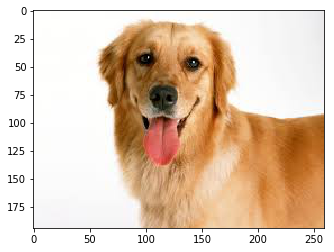

Golden_retriever



hello, dog!


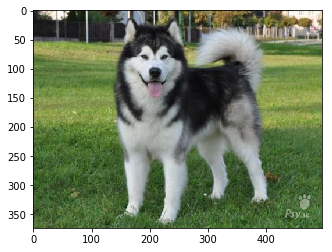

Alaskan_malamute



hello, dog!


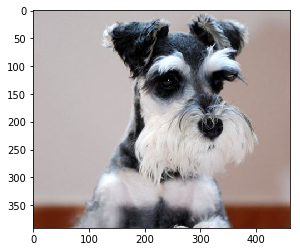

Miniature_schnauzer



hello, human!


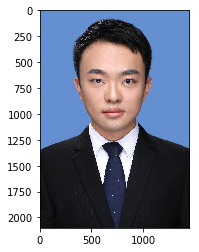

You look like a ...
Basenji



hello, human!


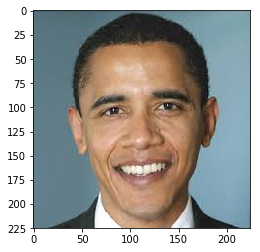

You look like a ...
Beagle



hello, human!


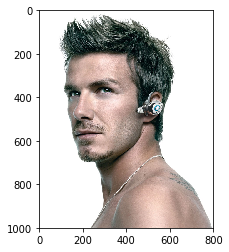

You look like a ...
English_toy_spaniel





False

In [32]:
## TODO: 在你的电脑上，在步骤6中，至少在6张图片上运行你的算法。
## 自由地使用所需的代码单元数吧
Predicter('testing/1.jpg')
print('\n' * 2)
Predicter('testing/2.jpg')
print('\n' * 2)
Predicter('testing/3.jpg')
print('\n' * 2)
Predicter('testing/4.jpg')
print('\n' * 2)
Predicter('testing/5.jpg')
print('\n' * 2)
Predicter('testing/6.jpg')
print('\n' * 2)
Predicter('testing/7.jpg')